# Preparing Time Series from Wide Form Data

In [70]:
#Full Name: Hannah Ploutz

## Imports & Load Data

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [72]:
df = pd.read_csv('Data/City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


## Part 1

In [73]:
# Filter the 4 largest cities into a new dataframe
df_4_cities = df[df['SizeRank'].isin([0, 1, 2, 3])]

In [74]:
# Get a list of columns that are formatted like dates (YYYY-MM-DD)
date_columns = [col for col in df.columns if "-" in col]

# Melt the DataFrame
df_melted = df_4_cities.melt(id_vars=["RegionName", "State", "SizeRank"],
                              value_vars=date_columns,
                              var_name="Date",
                              value_name="HomeValue")

In [75]:
print('RegionID' in df_melted['Date'].unique())

False


In [76]:
df_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  1092 non-null   object 
 1   State       1092 non-null   object 
 2   SizeRank    1092 non-null   int64  
 3   Date        1092 non-null   object 
 4   HomeValue   1087 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 42.8+ KB


In [77]:
# Convert the melted dates into datetime datatype
df_melted['Date'] = pd.to_datetime(df_melted['Date'])

In [78]:
# Make the datetime column the index
df_melted.set_index('Date', inplace=True)

# Resample the dataframe as monthly frequency, grouped by City
df_monthly = df_melted.groupby(['RegionName', pd.Grouper(freq='M')]).mean()

In [79]:
df_monthly.head()

SizeRank  HomeValue
RegionName Date                           
Chicago    2000-01-31       3.0   166139.0
           2000-02-29       3.0   166536.0
           2000-03-31       3.0   167368.0
           2000-04-30       3.0   168826.0
           2000-05-31       3.0   170499.0

## Part 2

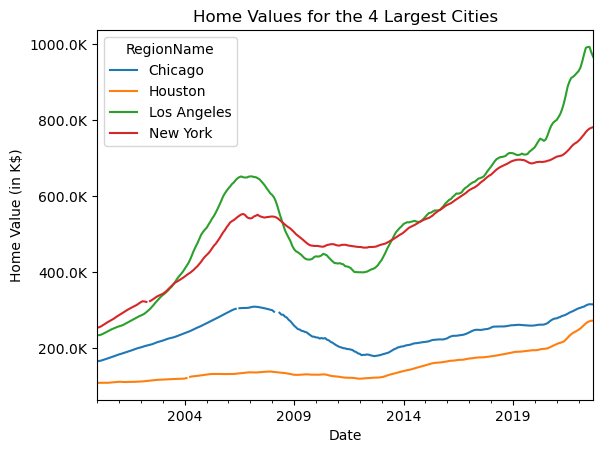

In [83]:
# Plot the home values for all 4 cities
df_unstacked = df_monthly['HomeValue'].unstack(level=0)
ax = df_unstacked.plot()

# Divide by 1000 and format with 'K' at the end
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x/1000}K'))

plt.title('Home Values for the 4 Largest Cities')
plt.xlabel('Date')
plt.ylabel('Home Value (in K$)')
plt.show()


In [81]:
# Answering question 1
# Filter for end of 2008 (December)
df_dec_2008 = df_unstacked.loc['2008-12-31']

# Find city with highest and lowest home value at end of 2008
highest_2008_city = df_dec_2008.idxmax()
lowest_2008_city = df_dec_2008.idxmin()

highest_2008_value = df_dec_2008.max()
lowest_2008_value = df_dec_2008.min()

print(f"The city with the highest Typical Home Value at the end of 2008 is {highest_2008_city} with a home value of ${highest_2008_value}")
print(f"The city with the lowest Typical Home Value at the end of 2008 is {lowest_2008_city} with a home value of ${lowest_2008_value}")

The city with the highest Typical Home Value at the end of 2008 is New York with a home value of $510309.0
The city with the lowest Typical Home Value at the end of 2008 is Houston with a home value of $131283.0


In [82]:
# Select rows for November and December 2008
nov_dec_2008 = df_unstacked.loc['2008-11-30':'2008-12-31']

# Calculate difference between December and November 2008
diff_nov_dec_2008 = nov_dec_2008.diff().dropna()

print("Change in home values from November 2008 to December 2008:")
print(diff_nov_dec_2008)

Change in home values from November 2008 to December 2008:
RegionName  Chicago  Houston  Los Angeles  New York
Date                                               
2008-12-31  -5753.0   -964.0     -12611.0   -4458.0


- You can see above that each Region had a decrease in their home values from Novemeber to December 2008